1,0.5048,0.4964
2,0.5084,0.5007
3,0.5364,0.5336
4,0.5605,0.5000
5,0.5873,0.5057
6,0.6059,0.5029
7,0.6359,0.5136
8,0.6587,0.5093
9,0.6732,0.4993
10,0.6877,0.5036
11,0.6850,0.5107
12,0.7154,0.4914
13,0.7252,0.5064
14,0.7325,0.4986
15,0.7386,0.5036
16,0.7500,0.5057
17,0.7445,0.5100
18,0.7670,0.5093
19,0.7414,0.5021
20,0.7348,0.4971


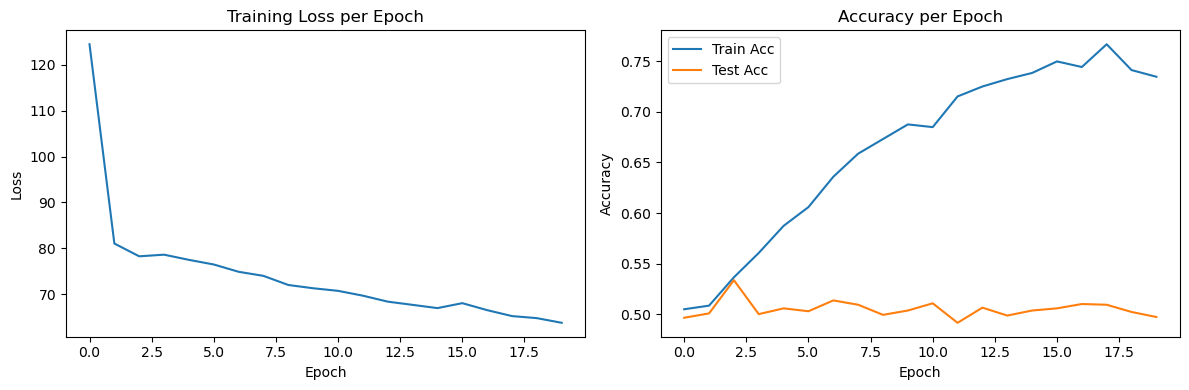

In [1]:
# Processed Data 1 (8 - 30HZ and tmin = -2, tmax = 1s)
# WNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Train-Test Split ===
train_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler on Sample Training Data ===
scaler = StandardScaler()
sample_data = []
for file in train_files[:5]:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Improved MLP Model (WNN-Inspired) ===
class WaveletNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# === Accuracy Calculation ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Training Loop ===
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)

        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    test_acc = get_accuracy(test_files)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"{epoch+1},{train_acc:.4f},{test_acc:.4f}")

# === Plot Training Loss and Accuracy ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


1,0.5232,0.5057
2,0.4971,0.4950
3,0.5452,0.5007
4,0.5448,0.5186
5,0.5655,0.5057
6,0.6029,0.4957
7,0.5793,0.5329
8,0.6623,0.5114
9,0.6643,0.5121
10,0.6834,0.5143
12,0.7239,0.5129
13,0.7230,0.4957
14,0.7143,0.5093
15,0.7354,0.5129
16,0.7075,0.5014
17,0.6995,0.4971
18,0.6984,0.5107
19,0.6955,0.5121
20,0.7264,0.4914


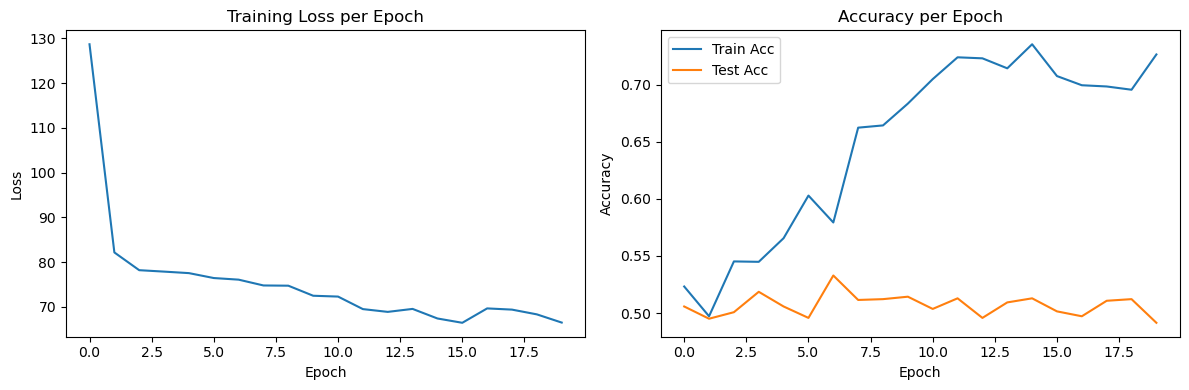


--- Train Set Evaluation ---
Accuracy:  0.7264
Precision: 0.8202
Recall:    0.5800
F1-score:  0.6795
AUC-ROC:   0.8240

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76      2800
           1       0.82      0.58      0.68      2800

    accuracy                           0.73      5600
   macro avg       0.75      0.73      0.72      5600
weighted avg       0.75      0.73      0.72      5600



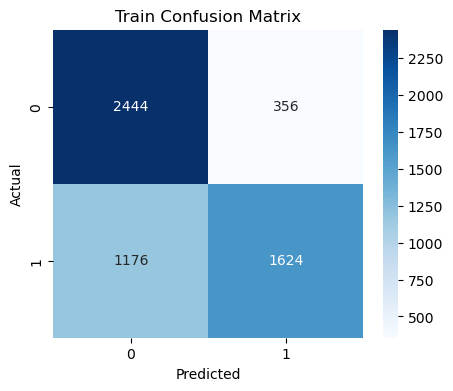

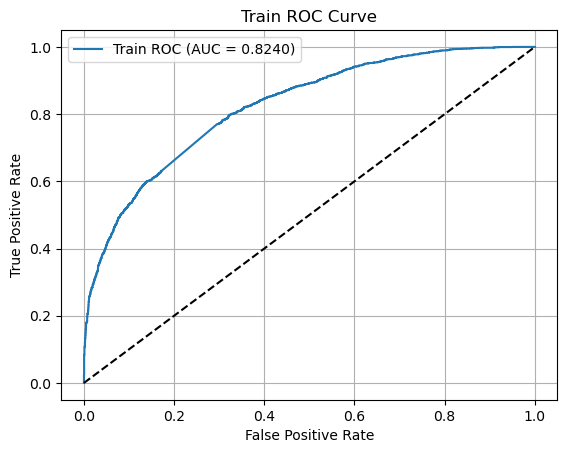


--- Test Set Evaluation ---
Accuracy:  0.4914
Precision: 0.4880
Recall:    0.3486
F1-score:  0.4067
AUC-ROC:   0.4914

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.56       700
           1       0.49      0.35      0.41       700

    accuracy                           0.49      1400
   macro avg       0.49      0.49      0.48      1400
weighted avg       0.49      0.49      0.48      1400



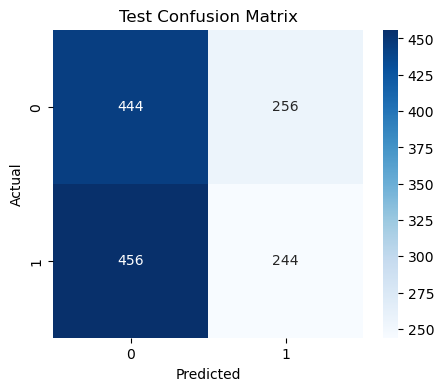

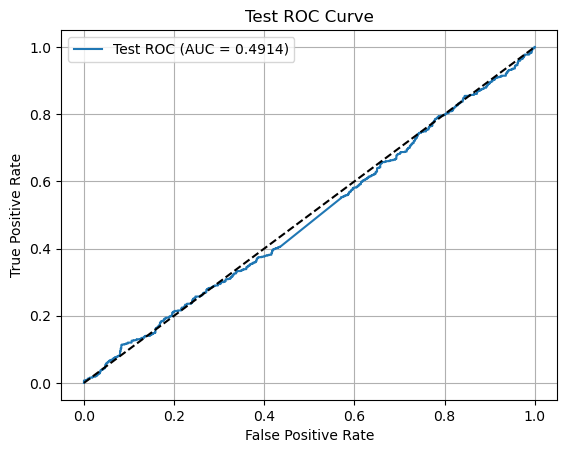

In [2]:
# Same code as above with evaluation matrix
# Processed Data 1 (8 - 30HZ and tmin = -2, tmax = 1s)
# WNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Train-Test Split ===
train_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler on Sample Training Data ===
scaler = StandardScaler()
sample_data = []
for file in train_files[:5]:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model Definition (WNN-Inspired) ===
class WaveletNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# === Basic Accuracy ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation Function with Metrics and Visualization ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)

            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)

        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    test_acc = get_accuracy(test_files)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"{epoch+1},{train_acc:.4f},{test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(test_files, set_name="Test")


1,0.5456,0.4978
2,0.6366,0.5145
3,0.6954,0.4942
4,0.7187,0.5058
5,0.7600,0.5145
6,0.8130,0.4913
7,0.8570,0.5108
8,0.8846,0.5152
9,0.9135,0.5029
10,0.9201,0.5094
11,0.9135,0.4993
12,0.9340,0.4971
13,0.9484,0.5210
14,0.9511,0.5173
15,0.9657,0.5130
16,0.9680,0.5166
17,0.9730,0.5130
18,0.9847,0.5253
19,0.9740,0.5260
20,0.9709,0.5173


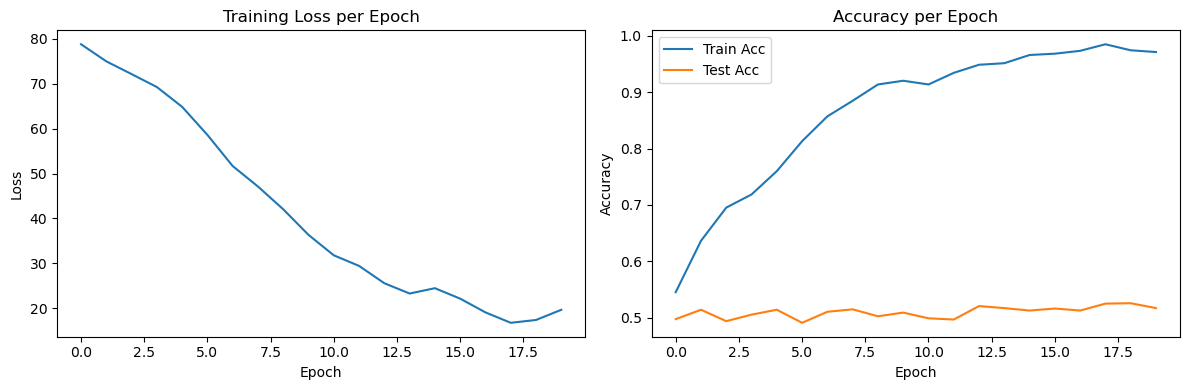


--- Train Set Evaluation ---
Accuracy:  0.9709
Precision: 0.9687
Recall:    0.9732
F1-score:  0.9710
AUC-ROC:   0.9953

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2578
           1       0.97      0.97      0.97      2576

    accuracy                           0.97      5154
   macro avg       0.97      0.97      0.97      5154
weighted avg       0.97      0.97      0.97      5154



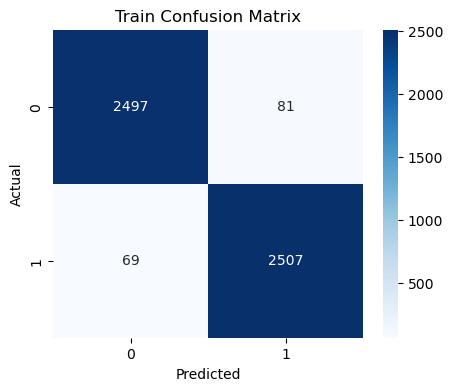

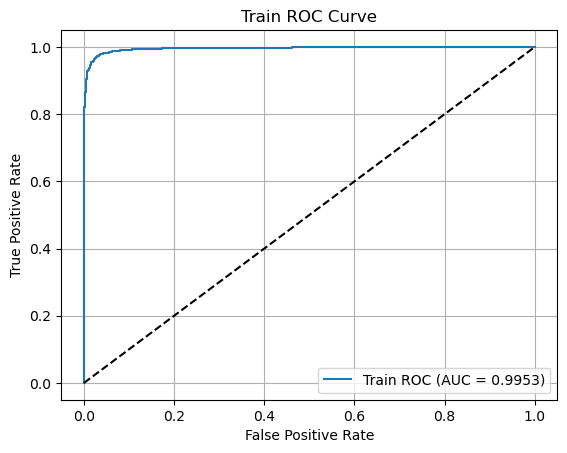


--- Test Set Evaluation ---
Accuracy:  0.5173
Precision: 0.5173
Recall:    0.4978
F1-score:  0.5074
AUC-ROC:   0.5316

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       693
           1       0.52      0.50      0.51       691

    accuracy                           0.52      1384
   macro avg       0.52      0.52      0.52      1384
weighted avg       0.52      0.52      0.52      1384



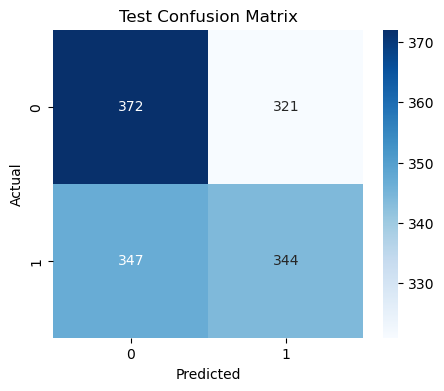

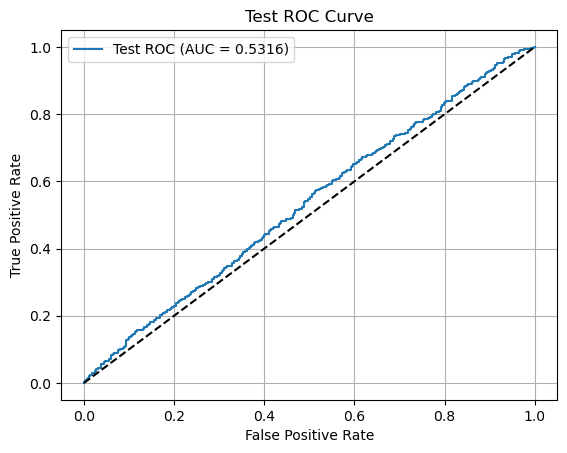

In [3]:
# Same code as above with evaluation matrix
# Processed Data 3 (8 - 30HZ and tmin = -2, tmax = 2s)
# WNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Train-Test Split ===
train_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler on Sample Training Data ===
scaler = StandardScaler()
sample_data = []
for file in train_files[:5]:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model Definition (WNN-Inspired) ===
class WaveletNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# === Basic Accuracy ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation Function with Metrics and Visualization ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)

            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)

        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    test_acc = get_accuracy(test_files)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"{epoch+1},{train_acc:.4f},{test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(test_files, set_name="Test")


/storage/projects1/e19-4yp-mi-eeg-for-bci/env/preprocess-env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Loss: 61.9626 - Train Acc: 0.5930 - Val Acc: 0.5013 - Test Acc: 0.5224
Epoch 2/50 - Loss: 57.9745 - Train Acc: 0.6530 - Val Acc: 0.4978 - Test Acc: 0.5130
Epoch 3/50 - Loss: 56.0945 - Train Acc: 0.6906 - Val Acc: 0.4943 - Test Acc: 0.5137
Epoch 4/50 - Loss: 50.9082 - Train Acc: 0.7580 - Val Acc: 0.5075 - Test Acc: 0.5152
Epoch 5/50 - Loss: 48.0924 - Train Acc: 0.8305 - Val Acc: 0.4996 - Test Acc: 0.5137
Epoch 6/50 - Loss: 41.3332 - Train Acc: 0.8661 - Val Acc: 0.4785 - Test Acc: 0.4964
Epoch 7/50 - Loss: 36.2500 - Train Acc: 0.8897 - Val Acc: 0.4925 - Test Acc: 0.4906
Epoch 8/50 - Loss: 30.2086 - Train Acc: 0.9188 - Val Acc: 0.5040 - Test Acc: 0.5022
Epoch 9/50 - Loss: 27.0703 - Train Acc: 0.9286 - Val Acc: 0.5198 - Test Acc: 0.5014
Epoch 10/50 - Loss: 23.6324 - Train Acc: 0.9574 - Val Acc: 0.5172 - Test Acc: 0.5101
Epoch 11/50 - Loss: 19.8800 - Train Acc: 0.9589 - Val Acc: 0.4881 - Test Acc: 0.5224
Epoch 12/50 - Loss: 18.6592 - Train Acc: 0.9614 - Val Acc: 0.4899 - Test A

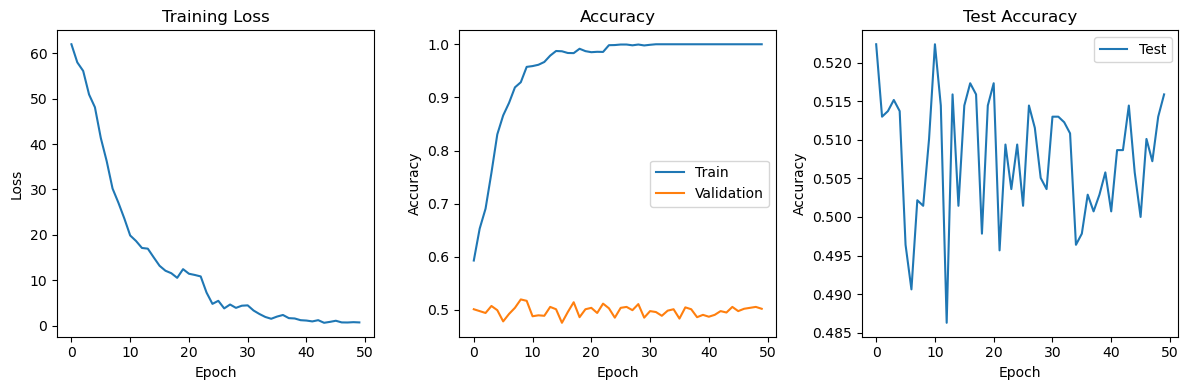


--- Train Set Evaluation ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000
AUC-ROC:   1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2005
           1       1.00      1.00      1.00      2012

    accuracy                           1.00      4017
   macro avg       1.00      1.00      1.00      4017
weighted avg       1.00      1.00      1.00      4017



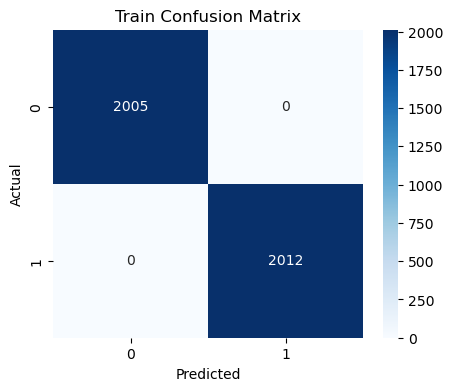

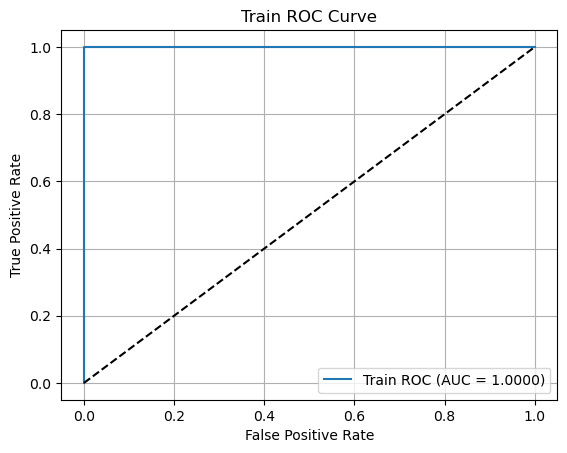


--- Validation Set Evaluation ---
Accuracy:  0.5022
Precision: 0.4982
Recall:    0.4894
F1-score:  0.4937
AUC-ROC:   0.5043

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       573
           1       0.50      0.49      0.49       564

    accuracy                           0.50      1137
   macro avg       0.50      0.50      0.50      1137
weighted avg       0.50      0.50      0.50      1137



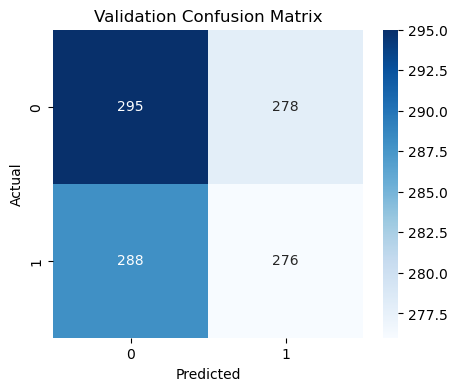

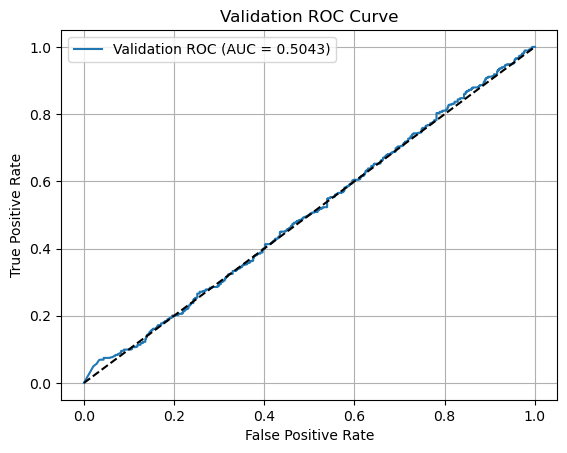


--- Test Set Evaluation ---
Accuracy:  0.5159
Precision: 0.5155
Recall:    0.5051
F1-score:  0.5102
AUC-ROC:   0.5184

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       693
           1       0.52      0.51      0.51       691

    accuracy                           0.52      1384
   macro avg       0.52      0.52      0.52      1384
weighted avg       0.52      0.52      0.52      1384



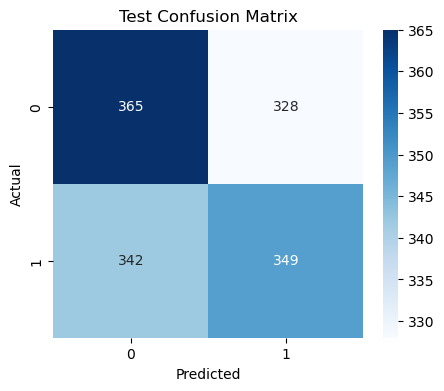

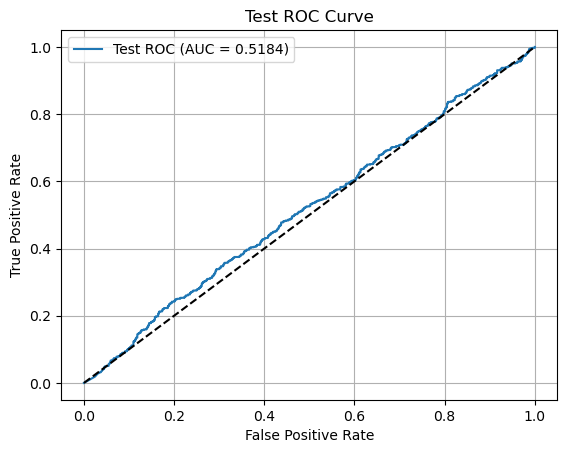

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Split Data ===
train_val_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)
train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler ===
scaler = StandardScaler()
sample_data = []
for file in train_files:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model ===
class WaveletNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Accuracy Function ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    val_acc = get_accuracy(val_files)
    test_acc = get_accuracy(test_files)

    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label="Test")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(val_files, set_name="Validation")
evaluate_model(test_files, set_name="Test")


/storage/projects1/e19-4yp-mi-eeg-for-bci/env/preprocess-env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Loss: 61.6182 - Train Acc: 0.6555 - Val Acc: 0.5084 - Test Acc: 0.5246
Epoch 2/50 - Loss: 56.3460 - Train Acc: 0.7217 - Val Acc: 0.4978 - Test Acc: 0.5231
Epoch 3/50 - Loss: 53.0778 - Train Acc: 0.7618 - Val Acc: 0.4925 - Test Acc: 0.5311
Epoch 4/50 - Loss: 50.1377 - Train Acc: 0.7974 - Val Acc: 0.4855 - Test Acc: 0.5231
Epoch 5/50 - Loss: 45.8621 - Train Acc: 0.8509 - Val Acc: 0.5004 - Test Acc: 0.5224
Epoch 6/50 - Loss: 43.4132 - Train Acc: 0.8544 - Val Acc: 0.5075 - Test Acc: 0.5152
Epoch 7/50 - Loss: 39.5680 - Train Acc: 0.8865 - Val Acc: 0.5048 - Test Acc: 0.5210
Epoch 8/50 - Loss: 37.1796 - Train Acc: 0.9066 - Val Acc: 0.4925 - Test Acc: 0.5152
Epoch 9/50 - Loss: 33.6539 - Train Acc: 0.9024 - Val Acc: 0.5013 - Test Acc: 0.5188
Epoch 10/50 - Loss: 32.3864 - Train Acc: 0.9340 - Val Acc: 0.4996 - Test Acc: 0.5217
Epoch 11/50 - Loss: 31.7563 - Train Acc: 0.9251 - Val Acc: 0.4899 - Test Acc: 0.5246
Epoch 12/50 - Loss: 29.5475 - Train Acc: 0.9408 - Val Acc: 0.5031 - Test A

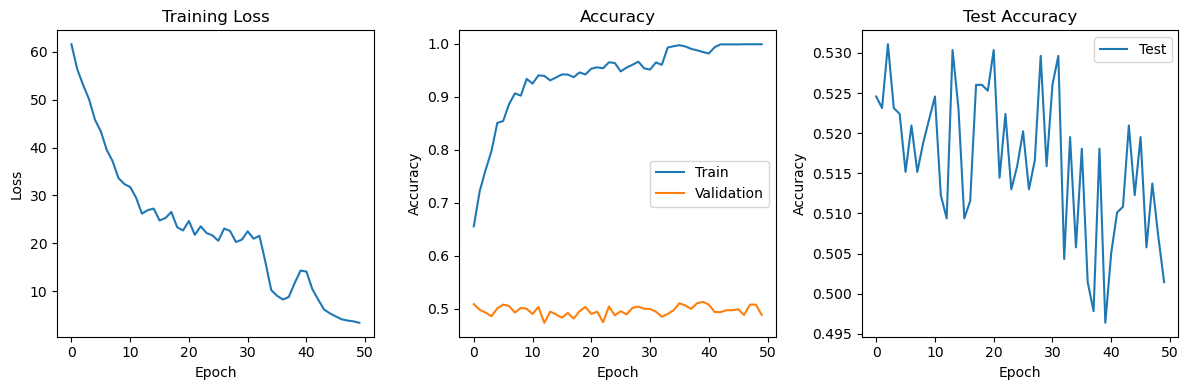


--- Train Set Evaluation ---
Accuracy:  0.9995
Precision: 0.9990
Recall:    1.0000
F1-score:  0.9995
AUC-ROC:   1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2005
           1       1.00      1.00      1.00      2012

    accuracy                           1.00      4017
   macro avg       1.00      1.00      1.00      4017
weighted avg       1.00      1.00      1.00      4017



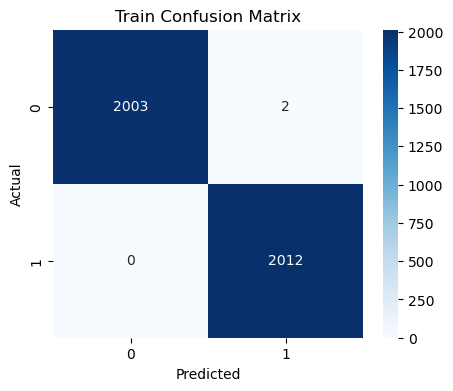

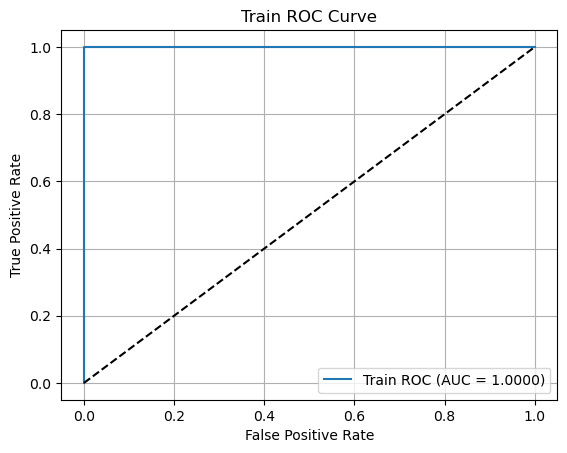


--- Validation Set Evaluation ---
Accuracy:  0.4881
Precision: 0.4855
Recall:    0.5355
F1-score:  0.5093
AUC-ROC:   0.4907

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.44      0.47       573
           1       0.49      0.54      0.51       564

    accuracy                           0.49      1137
   macro avg       0.49      0.49      0.49      1137
weighted avg       0.49      0.49      0.49      1137



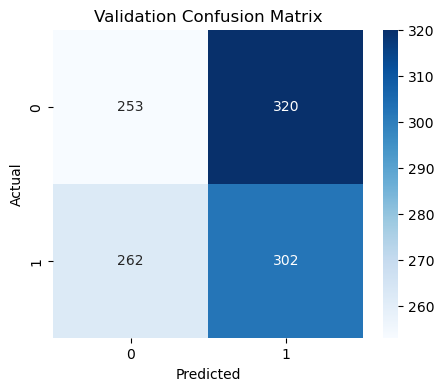

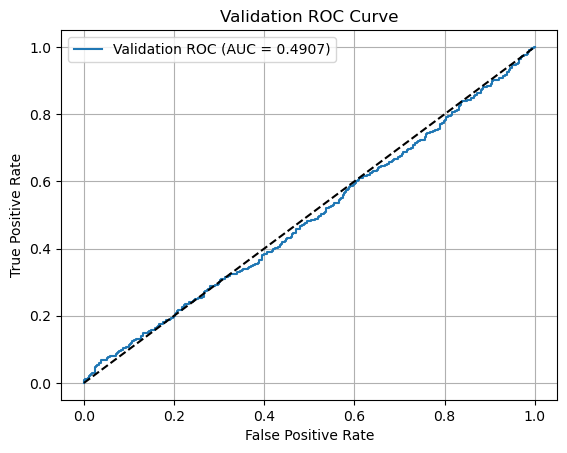


--- Test Set Evaluation ---
Accuracy:  0.5014
Precision: 0.5007
Recall:    0.4964
F1-score:  0.4985
AUC-ROC:   0.5154

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       693
           1       0.50      0.50      0.50       691

    accuracy                           0.50      1384
   macro avg       0.50      0.50      0.50      1384
weighted avg       0.50      0.50      0.50      1384



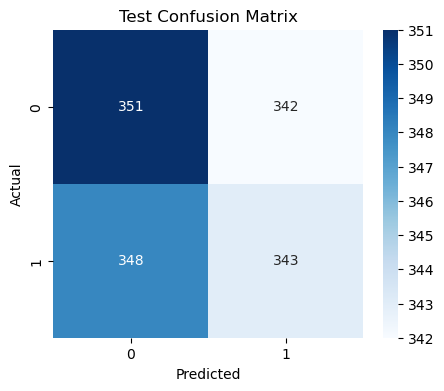

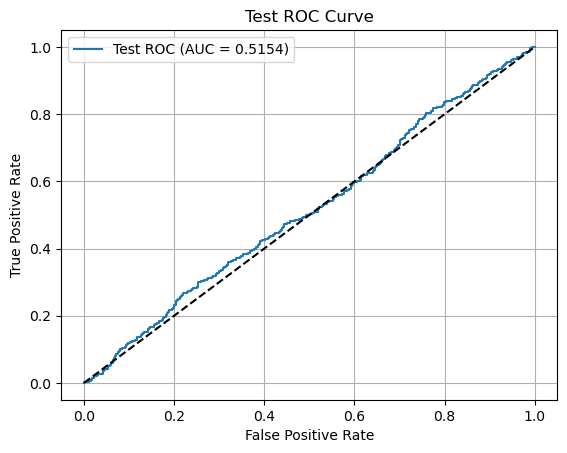

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Split Data ===
train_val_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)
train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler ===
scaler = StandardScaler()
sample_data = []
for file in train_files:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model ===
class WaveletNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Accuracy Function ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    val_acc = get_accuracy(val_files)
    test_acc = get_accuracy(test_files)

    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label="Test")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(val_files, set_name="Validation")
evaluate_model(test_files, set_name="Test")


/storage/projects1/e19-4yp-mi-eeg-for-bci/env/preprocess-env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Loss: 61.5731 - Train Acc: 0.6565 - Val Acc: 0.4952 - Test Acc: 0.5238
Epoch 2/50 - Loss: 58.0479 - Train Acc: 0.6667 - Val Acc: 0.5075 - Test Acc: 0.5094
Epoch 3/50 - Loss: 57.5978 - Train Acc: 0.6706 - Val Acc: 0.4978 - Test Acc: 0.5173
Epoch 4/50 - Loss: 57.2913 - Train Acc: 0.6684 - Val Acc: 0.4925 - Test Acc: 0.5159
Epoch 5/50 - Loss: 57.4803 - Train Acc: 0.6500 - Val Acc: 0.5128 - Test Acc: 0.5246
Epoch 6/50 - Loss: 57.5740 - Train Acc: 0.6395 - Val Acc: 0.4996 - Test Acc: 0.5159
Epoch 7/50 - Loss: 57.5485 - Train Acc: 0.6355 - Val Acc: 0.5189 - Test Acc: 0.5282
Epoch 8/50 - Loss: 57.7022 - Train Acc: 0.6395 - Val Acc: 0.5092 - Test Acc: 0.5152
Epoch 9/50 - Loss: 56.0382 - Train Acc: 0.6796 - Val Acc: 0.4996 - Test Acc: 0.5130
Epoch 10/50 - Loss: 55.6733 - Train Acc: 0.6990 - Val Acc: 0.4978 - Test Acc: 0.5166
Epoch 11/50 - Loss: 55.0549 - Train Acc: 0.6886 - Val Acc: 0.5110 - Test Acc: 0.5253
Epoch 12/50 - Loss: 54.3772 - Train Acc: 0.7090 - Val Acc: 0.5101 - Test A

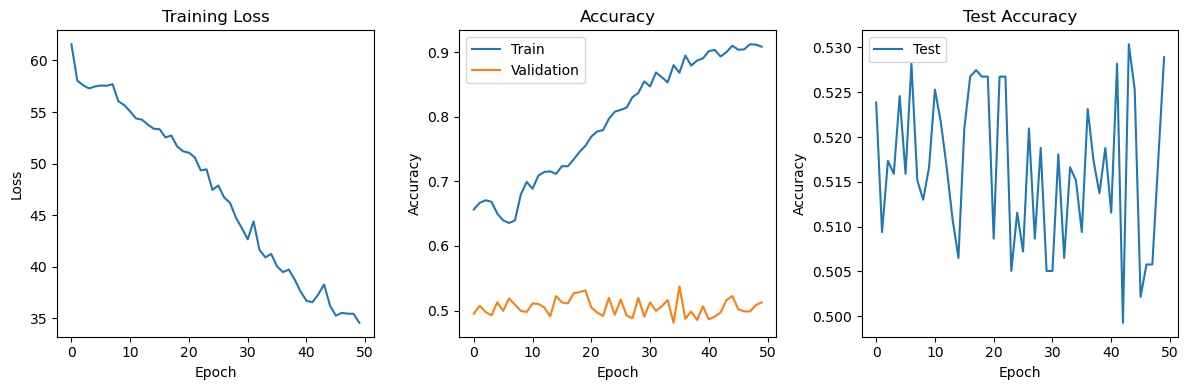


--- Train Set Evaluation ---
Accuracy:  0.9084
Precision: 0.8990
Recall:    0.9205
F1-score:  0.9096
AUC-ROC:   0.9679

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2005
           1       0.90      0.92      0.91      2012

    accuracy                           0.91      4017
   macro avg       0.91      0.91      0.91      4017
weighted avg       0.91      0.91      0.91      4017



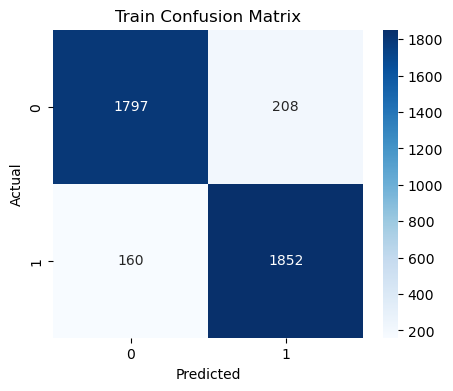

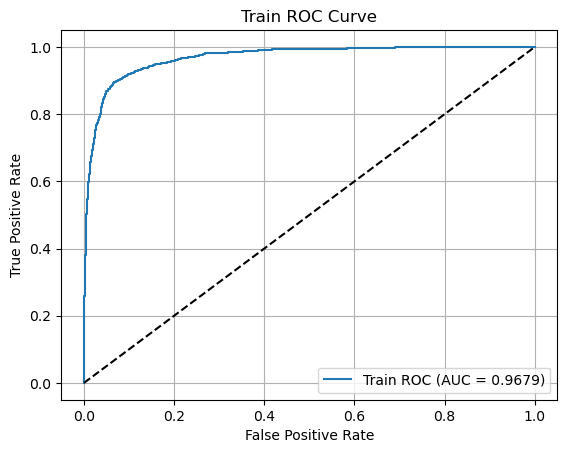


--- Validation Set Evaluation ---
Accuracy:  0.5128
Precision: 0.5076
Recall:    0.5904
F1-score:  0.5459
AUC-ROC:   0.5126

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.47       573
           1       0.51      0.59      0.55       564

    accuracy                           0.51      1137
   macro avg       0.51      0.51      0.51      1137
weighted avg       0.51      0.51      0.51      1137



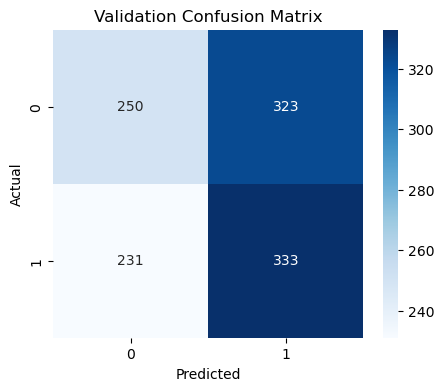

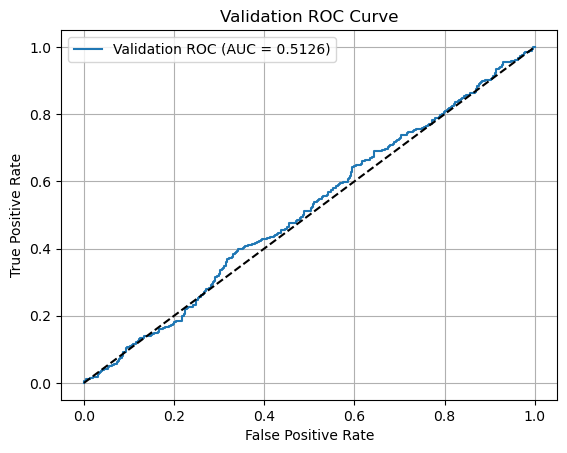


--- Test Set Evaluation ---
Accuracy:  0.5289
Precision: 0.5261
Recall:    0.5687
F1-score:  0.5466
AUC-ROC:   0.5334

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       693
           1       0.53      0.57      0.55       691

    accuracy                           0.53      1384
   macro avg       0.53      0.53      0.53      1384
weighted avg       0.53      0.53      0.53      1384



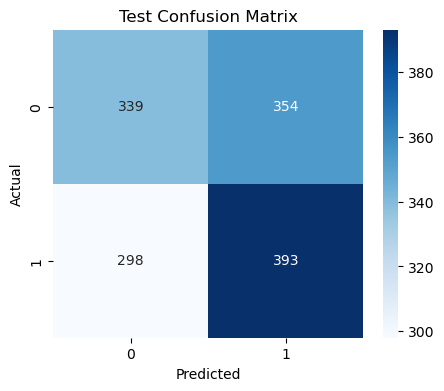

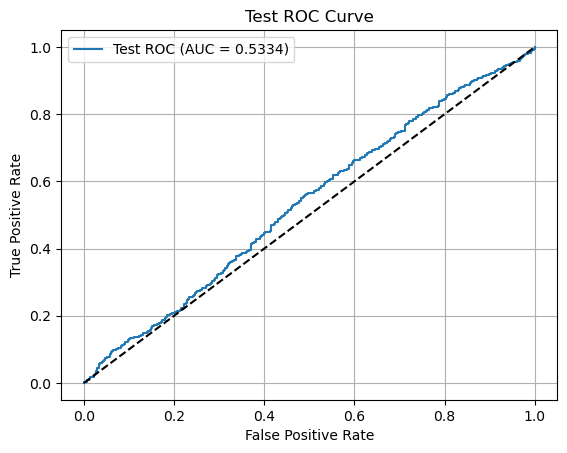

In [7]:
# Further simplified the model WNN
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Split Data ===
train_val_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)
train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler ===
scaler = StandardScaler()
sample_data = []
for file in train_files:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model ===
class WaveletNetSimplified(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNetSimplified, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Accuracy Function ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    val_acc = get_accuracy(val_files)
    test_acc = get_accuracy(test_files)

    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label="Test")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(val_files, set_name="Validation")
evaluate_model(test_files, set_name="Test")


/storage/projects1/e19-4yp-mi-eeg-for-bci/env/preprocess-env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Loss: 61.6213 - Train Acc: 0.5601 - Val Acc: 0.5004 - Test Acc: 0.5079
Epoch 2/30 - Loss: 59.2457 - Train Acc: 0.5536 - Val Acc: 0.5031 - Test Acc: 0.5275
Epoch 3/30 - Loss: 58.8946 - Train Acc: 0.5569 - Val Acc: 0.5022 - Test Acc: 0.5217
Epoch 4/30 - Loss: 58.5737 - Train Acc: 0.5512 - Val Acc: 0.4978 - Test Acc: 0.5116
Epoch 5/30 - Loss: 58.4139 - Train Acc: 0.5434 - Val Acc: 0.5084 - Test Acc: 0.5152
Epoch 6/30 - Loss: 58.2942 - Train Acc: 0.5365 - Val Acc: 0.4881 - Test Acc: 0.5123
Epoch 7/30 - Loss: 58.3108 - Train Acc: 0.5390 - Val Acc: 0.4828 - Test Acc: 0.5079
Epoch 8/30 - Loss: 58.2497 - Train Acc: 0.5372 - Val Acc: 0.5004 - Test Acc: 0.5116
Epoch 9/30 - Loss: 58.2544 - Train Acc: 0.5325 - Val Acc: 0.4820 - Test Acc: 0.5094
Epoch 10/30 - Loss: 58.2485 - Train Acc: 0.5335 - Val Acc: 0.4846 - Test Acc: 0.5195
Epoch 11/30 - Loss: 58.2450 - Train Acc: 0.5355 - Val Acc: 0.4749 - Test Acc: 0.5253
Epoch 12/30 - Loss: 58.2631 - Train Acc: 0.5350 - Val Acc: 0.4925 - Test A

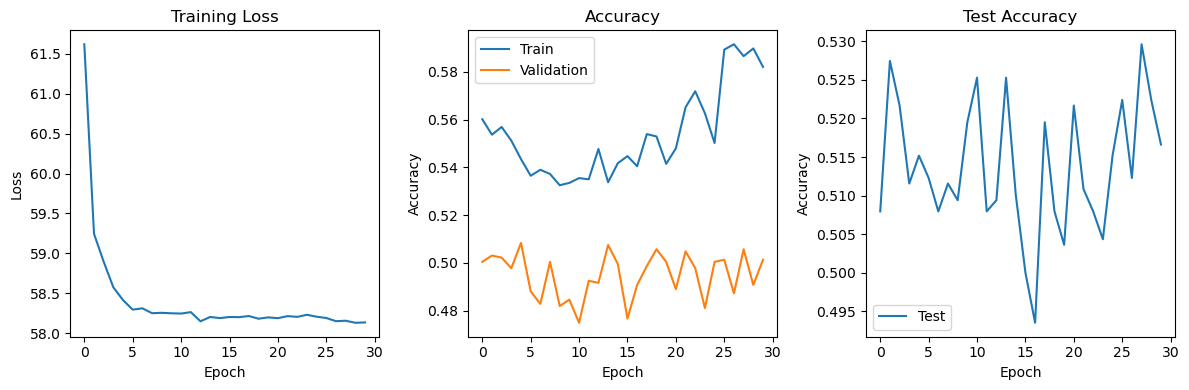


--- Train Set Evaluation ---
Accuracy:  0.5820
Precision: 0.5600
Recall:    0.7729
F1-score:  0.6494
AUC-ROC:   0.6271

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.39      0.48      2005
           1       0.56      0.77      0.65      2012

    accuracy                           0.58      4017
   macro avg       0.60      0.58      0.57      4017
weighted avg       0.60      0.58      0.57      4017



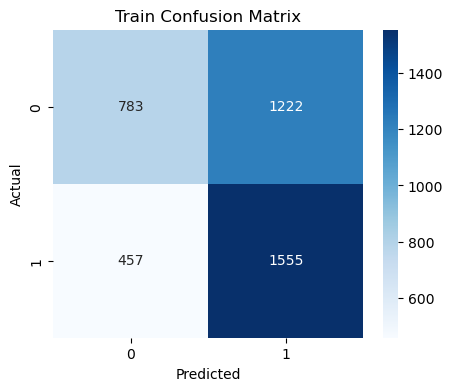

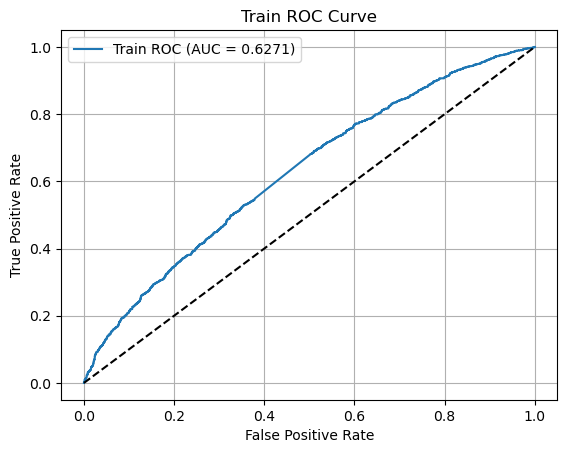


--- Validation Set Evaluation ---
Accuracy:  0.5013
Precision: 0.4981
Recall:    0.7004
F1-score:  0.5822
AUC-ROC:   0.4979

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.31      0.38       573
           1       0.50      0.70      0.58       564

    accuracy                           0.50      1137
   macro avg       0.50      0.50      0.48      1137
weighted avg       0.50      0.50      0.48      1137



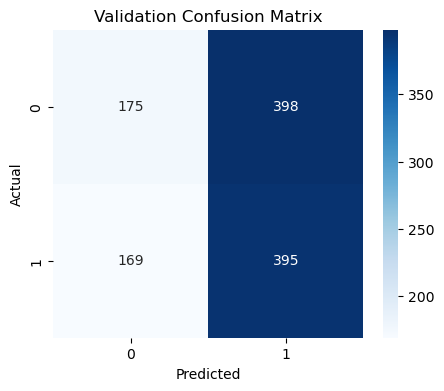

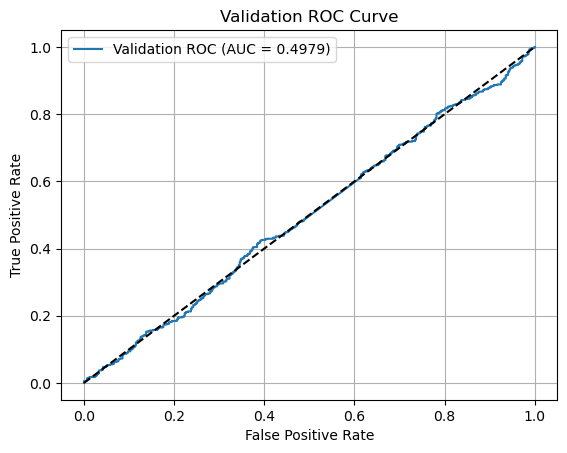


--- Test Set Evaluation ---
Accuracy:  0.5166
Precision: 0.5115
Recall:    0.7091
F1-score:  0.5943
AUC-ROC:   0.5230

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40       693
           1       0.51      0.71      0.59       691

    accuracy                           0.52      1384
   macro avg       0.52      0.52      0.50      1384
weighted avg       0.52      0.52      0.50      1384



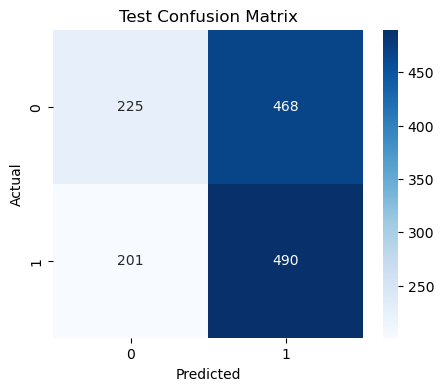

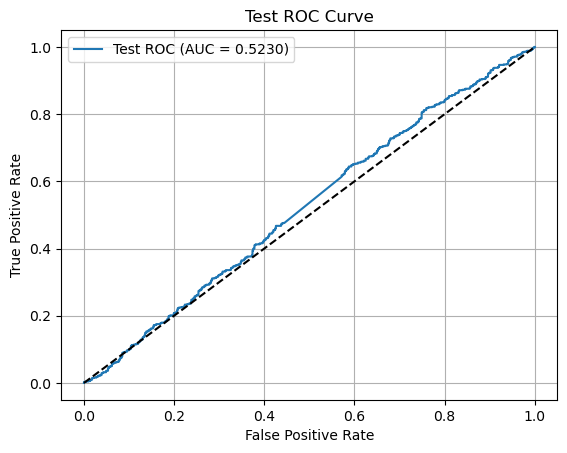

In [8]:
# Further simplified the model WNN
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 30
batch_size = 64

# === Load File List and Labels ===
npz_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npz')])

all_labels = []
for file in npz_files:
    y = np.load(file)['y']
    all_labels.extend(y)
all_labels = np.array(all_labels)

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# === Split Data ===
train_val_files, test_files = train_test_split(npz_files, test_size=0.2, random_state=42, shuffle=True)
train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42, shuffle=True)

# === Fit Scaler ===
scaler = StandardScaler()
sample_data = []
for file in train_files:
    X = np.load(file)['X']
    X = X.reshape(X.shape[0], -1)
    sample_data.append(X)
scaler.fit(np.vstack(sample_data))

# === Model ===
class WaveletNetSimplified(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WaveletNetSimplified, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# === Initialize Model ===
sample_input = sample_data[0]
model = WaveletNet(input_dim=sample_input.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Accuracy Function ===
def get_accuracy(files):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y, dtype=torch.long).to(device)

            outputs = model(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_tensor).sum().item()
            total += y_tensor.size(0)
    return correct / total

# === Evaluation ===
def evaluate_model(files, set_name="Test"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for file in files:
            data = np.load(file)
            X, y = data['X'], data['y']
            X = X.reshape(X.shape[0], -1)
            X = scaler.transform(X)
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y)
            y_pred.extend(predictions)
            y_prob.extend(probabilities)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n--- {set_name} Set Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_prob):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{set_name} ROC (AUC = {roc_auc_score(y_true, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Training Loop ===
train_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for file in train_files:
        data = np.load(file)
        X, y = data['X'], data['y']
        X = X.reshape(X.shape[0], -1)
        X = scaler.transform(X)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(device)

        for start in range(0, len(X_tensor), batch_size):
            end = start + batch_size
            X_batch = X_tensor[start:end]
            y_batch = y_tensor[start:end]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    train_acc = get_accuracy(train_files)
    val_acc = get_accuracy(val_files)
    test_acc = get_accuracy(test_files)

    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - Test Acc: {test_acc:.4f}")

# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label="Test")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Final Evaluation ===
evaluate_model(train_files, set_name="Train")
evaluate_model(val_files, set_name="Validation")
evaluate_model(test_files, set_name="Test")
